# <center>CITS5508 Machine Learning - Lab Sheet 5</center>

**Name: Isaac Huang  
Student ID: 23019722  
File name: Huang_Isaac_lab05.ipyn**

## CIFAR-10 Dataset Class Labels
- airplane : 0
- automobile : 1
- bird : 2
- cat : 3
- deer : 4
- dog : 5
- frog : 6
- horse : 7
- ship : 8
- truck : 9

## 1. Import Necessary Libraries   

In [1]:
from data_loader import DataLoader

import numpy as np
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras.utils import to_categorical 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Conv2D, MaxPooling2D

## 2. Load Data Python Function DataLoader

In [10]:
image_width, image_height, image_Nchannels = 32, 32, 3
class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

X_train, y_train = DataLoader.load_batch('data_batch')
X_test, y_test = DataLoader.load_batch('test_batch', Nbatches=1)

## 3. Random Sampled Images Display
- 20 sampled images from training set
- 20 sampled images from validation set
- 20 sampled images from test set

In [11]:
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state = 15, shuffle=True)

def sampled_images(row, col, X, y):
    (X_rand, y_rand) = shuffle(X, y)
    fig, axes = plt.subplots(row,col,figsize = (10,9))
    axes = axes.ravel()
    for i in range(0, row*col):
        axes[i].imshow(X_rand[i])
        axes[i].set_title("{}".format(class_names[y_rand.item(i)]))
        axes[i].axis('off')
    return

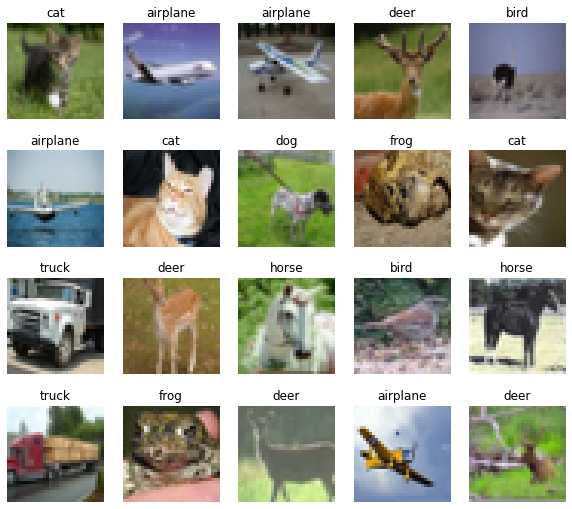

In [12]:
X=X_tra
y=y_tra
sampled_images(4, 5, X, y)
plt.show()

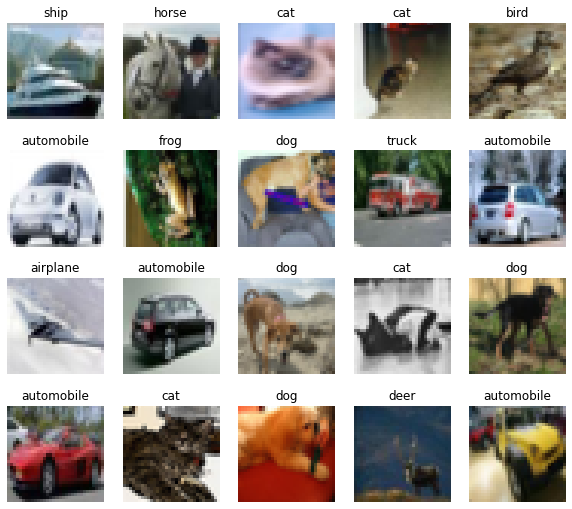

In [42]:
X=X_val
y=y_val
sampled_images(4, 5, X, y)
plt.show()

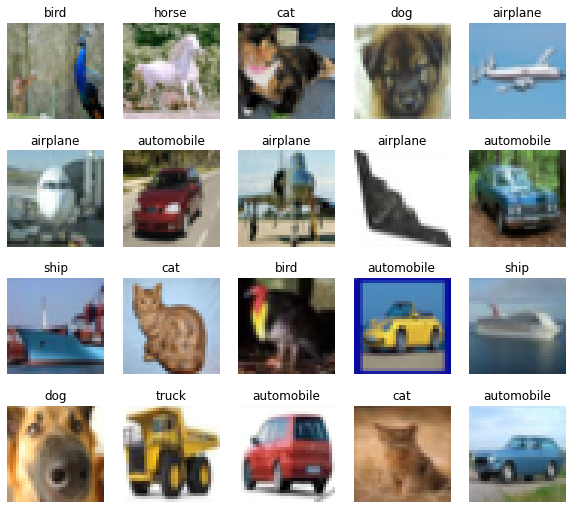

In [43]:
X=X_test
y=y_test
sampled_images(4, 5, X, y)
plt.show()

## 4. Shape of All Datasets

In [13]:
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)
X_tra, X_val, y_tra, y_val = train_test_split(X_train, y_train, test_size=0.15, random_state = 15, shuffle=True)

print('X_train.shape =', X_tra.shape, 'data type:', X_tra.dtype)
print('y_train.shape =', y_tra.shape, 'data type:', y_tra.dtype)
print('X_val.shape =', X_val.shape, 'data type:', X_val.dtype)
print('y_val.shape =', y_val.shape, 'data type:', y_val.dtype)
print('X_test.shape =', X_test.shape, 'data type:', X_test.dtype)
print('y_test.shape =', y_test.shape, 'data type:', y_test.dtype)

X_train.shape = (42500, 32, 32, 3) data type: float32
y_train.shape = (42500, 10) data type: float32
X_val.shape = (7500, 32, 32, 3) data type: float32
y_val.shape = (7500, 10) data type: float32
X_test.shape = (10000, 32, 32, 3) data type: float32
y_test.shape = (10000, 10) data type: float32


## 5. Build MLP Model with Keras
- Use 3 hidden layers and an output layer.
- Use the validation set with Early Stopping to overcome overfitting.
- Use GridSearchCV to tune the parameters.
- Use ReLU as activation function for slightly faster training.

In [53]:
def create_model(weight_init, learning_rate, dropout_rate):
    
    model = Sequential()
    model.add(Flatten(input_shape = X_val.shape[1:]))
    
    model.add(Dense(1024, kernel_initializer = weight_init, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(512, kernel_initializer = weight_init, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(256, kernel_initializer = weight_init, activation = 'relu'))
    model.add(Dropout(dropout_rate))
    
    model.add(Dense(10, activation = 'softmax'))
    
    adam = Adam(learning_rate = learning_rate)
    model.compile(loss = 'categorical_crossentropy', optimizer = adam, metrics = ['accuracy'])
    
    return model

In [54]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model = KerasClassifier(build_fn = create_model, batch_size = 32, epochs = 100, callbacks=[stop_early])

weight_init = ['uniform', 'normal', 'zero']
dropout_rate = [0.1, 0.2, 0.4]
learning_rate = [0.001, 0.01, 0.1]


params = dict(weight_init = weight_init, learning_rate = learning_rate, dropout_rate = dropout_rate)

grid = GridSearchCV(estimator = model, param_grid = params, n_jobs=-1)
grid_result = grid.fit(X_val, y_val)

print('MLP : {}, using {}'.format(grid_result.best_score_, grid_result.best_params_))

## 6. MLP Model Summary, Prediction Performance & Save Model

In [ ]:
model.summary()
model.save('Huang_Isaac-MLP')

In [ ]:
y_pred = model.predict(X_test)
print('Results on the test set:')
print(classification_report(y_test, y_pred))

## 7. Build CNN Model with Keras
- Use 3 convolutional layers with a pooling layer in between.
- Use the validation set with Early Stopping to overcome overfitting.
- Use GridSearchCV to tune the parameters.
- Use padding = 'same'.

In [14]:
def create_model_2(kernel, kernel_size, activation):
    
    model = Sequential()
    model.add(Conv2D(filters=kernel, kernel_size=kernel_size, activation=activation, input_shape=X_val.shape[1:]))
    model.add(MaxPooling2D(2,2))
    
    model.add(Conv2D(filters=kernel, kernel_size=kernel_size, activation=activation, padding='same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))
    
    model.add(Conv2D(filters=kernel, kernel_size=kernel_size, activation=activation, padding='same'))
    model.add(MaxPooling2D(2,2))
    model.add(Dropout(0.2))
    
    model.add(Flatten())
    model.add(Dense(10,activation='softmax'))
    
    opt = keras.optimizers.RMSprop(learning_rate=0.0001, decay=1e-6)
    model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
    
    return model

In [18]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
model_2 = KerasClassifier(build_fn = create_model_2, batch_size = 32, epochs = 100, callbacks=[stop_early])

kernel = [16, 32, 64]
kernel_size = [(3, 3), (4, 4), (5, 5)]
activation = ['relu', 'tanh', 'selu']

params_2 = dict(kernel = kernel, kernel_size = kernel_size, activation = activation)

grid_2 = GridSearchCV(estimator = model_2, param_grid = params_2, n_jobs=-1)
grid_result_2 = grid_2.fit(X_val, y_val)

print('CNN : {}, using {}'.format(grid_result_2.best_score_, grid_result_2.best_params_))

## 8. CNN Model Summary, Prediction Performance & Save Model

In [ ]:
model_2.summary()
model_2.save('Huang_Isaac-CNN')

In [ ]:
y_pred_2 = model_2.predict(X_test)
print('Results on the test set:')
print(classification_report(y_test, y_pred_2))